In [3]:
%pip install ipywidgets


Note: you may need to restart the kernel to use updated packages.


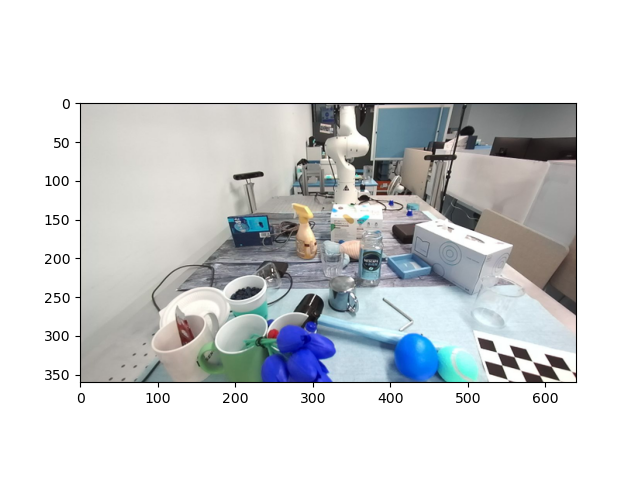

[[ 0.40029102  0.0090291   0.05028906]
 [ 0.40390254 -0.00616401  0.04413502]
 [ 0.40390254 -0.00616401  0.04413502]
 [ 0.40390254 -0.00616401  0.04413502]
 [ 0.40389568 -0.01366773  0.04434328]
 [ 0.40756549  0.03492075  0.03641907]
 [ 0.40757922  0.04992806  0.03600255]
 [ 0.40941928  0.07985009  0.03188422]
 [ 0.40941585  0.07609823  0.03198835]
 [ 0.40941585  0.07609823  0.03198835]
 [ 0.4129965   0.02713852  0.02677149]
 [ 0.41293475 -0.04039493  0.02864584]
 [ 0.41111184 -0.05155766  0.03224351]
 [ 0.40212423  0.03144741  0.04637899]
 [ 0.40937812  0.03482791  0.03313379]
 [ 0.40034591  0.06905871  0.04862297]
 [ 0.40759637  0.06868735  0.03548189]
 [ 0.40759637  0.06868735  0.03548189]
 [ 0.40940556  0.06484266  0.03230074]
 [ 0.4165943  -0.00306202  0.02103397]]


In [13]:
%matplotlib widget

import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as wdg
from PIL import Image
import cv2

# Data processing
fig = plt.figure()
img_path = "../../../datasets/extrinsics/rgb_1.png"
depth_path = "../../../datasets/extrinsics/depth_1.png"
extr_path = "../../../datasets/extrinsics/cam_1_extrinsics.npy"
intr_path = "../../../datasets/extrinsics/intrinsics_1.npy"

img = Image.open(img_path).convert('RGB')
depth = cv2.imread(depth_path, cv2.IMREAD_UNCHANGED).astype(np.float32)
extr = np.load(extr_path).astype(np.float32)
extr = extr @ np.diag([1, -1, -1, 1])
extr = np.linalg.inv(extr)
intr = np.load(intr_path).astype(np.float32)

new_width = img.width // 2
new_height = img.height // 2
img_half = img.resize((new_width, new_height), Image.Resampling.LANCZOS)

depth_half = cv2.resize(depth, (new_width, new_height), interpolation=cv2.INTER_NEAREST)

intr[0][0] = intr[0][0]/2
intr[0][2] = intr[0][2]/2 
intr[1][1] = intr[1][1]/2
intr[1][2] = intr[1][2]/2


# Lifting
H, W = depth_half.shape
N = H * W  # Total number of pixels

u, v = np.meshgrid(np.arange(W), np.arange(H), indexing='xy')
ones = np.ones_like(u)

pix = np.stack((u, v, ones), axis=-1).reshape(N, 3).astype(np.float32)

K_inv = np.linalg.inv(intr)  # (3, 3)
cam_coords_normalized = K_inv @ pix.T
cam_coords = cam_coords_normalized * depth_half.flatten().reshape(1, N)  # (3, N)


R = extr[:3, :3]
t = extr[:3, 3]  
world_coords = R.T @ (cam_coords - t.reshape(3, 1))  # (3, N)
pcd = world_coords.T.reshape(H, W, 3)

plt.imshow(img_half)

query_point_ls = []

def onclick(event):
    if event.xdata is None or event.ydata is None:
        return
    x_pixel = round(event.xdata)
    y_pixel = round(event.ydata)
    query_point_ls.append(pcd[y_pixel, x_pixel, :].copy())
    if(len(query_point_ls)==20):
        print(np.array(query_point_ls))
        np.save("../../../datasets/extrinsics/query_point.npy",np.array(query_point_ls))

# Create an hard reference to the callback not to be cleared by the garbage collector
ka = fig.canvas.mpl_connect('button_press_event', onclick)

In [26]:
plt.close('all')